## Twisted Diffusion Sampler (TDS)

The **Twisted Diffusion Sampler (TDS)** is a Sequential Monte Carlo (SMC) method designed for conditional sampling from diffusion models. It addresses the challenge of sampling from a posterior distribution $p(x_0 | y)$ given a measurement $y$, where the prior $p(x_0)$ is defined by a pre-trained diffusion model.

Standard diffusion guidance methods (like classifier guidance) approximate the conditional score $\nabla_{x_t} \log p(x_t | y)$. TDS improves upon this by introducing a "twisting" function (or auxiliary target) $\tilde{p}(y|x_t)$ to guide the intermediate proposal distributions in an SMC framework.

### Key Steps in Algorithm 1:
1.  **Initialization**: Start with particles $x_T$ from the standard normal prior and assign initial weights based on the twisting function.
2.  **Resampling**: At each timestep, resample particles based on their importance weights to focus on high-probability regions.
3.  **Conditional Score Approximation**: Compute a "twisted" score that combines the unconditional diffusion score with the gradient of the twisting function $\nabla_{x_t} \log \tilde{p}(y|x_t)$.
4.  **Proposal Step**: Propagate particles to the next timestep $x_{t-1}$ using the twisted score (similar to guidance).
5.  **Weight Update**: Update particle weights to account for the discrepancy between the optimal target distribution and the proposal distribution.

In [4]:
import torch

def twisted_diffusion_sampler(model, y, mask, K, T, sigmas):
    # 1. Initialisation
    x = torch.randn(K, channels, h, w)
    weights = calculate_twisting_function(x, y, mask, T)

    for t in reversed(range(T)):
        # 2. Resampling
        indices = torch.multinomial(weights, K, replacement=True)
        x = x[indices]

        # 3. Score & Gradient
        x.requires_grad_(True)
        # Calculer log p_tilde (la ressemblance avec y)
        log_p_tilde = calculate_log_twisting(model, x, y, mask, t)
        grad_log_p = torch.autograd.grad(log_p_tilde.sum(), x)[0]

        # Score standard du modèle de diffusion
        with torch.no_grad():
            x0_hat = model.predict_x0(x, t)
            score = (x0_hat - x) / (sigmas[t]**2)

            # Twisted Score (Ligne 6)
            s_tilde = score + grad_log_p

            # 4. Update (Ligne 7)
            noise = torch.randn_like(x)
            x = x + (sigmas[t]**2) * s_tilde + sigmas_step[t] * noise

            # 5. Update weights (Ligne 9)
            weights = update_weights(x, y, mask, t)

    return x


def update_weights(x_t, x_t_plus_1, y, mask, t, model, sigmas):
    """
    Calcule les nouveaux poids basés sur le rapport entre
    la probabilité de transition réelle et la proposition 'twisted'.
    """
    # 1. Calcul de p_theta(x_t | x_t_plus_1) - Transition standard
    # C'est la probabilité que le modèle de diffusion "normal" passe de t+1 à t
    x0_pred = model.predict_x0(x_t_plus_1, t+1)
    mu_standard = compute_diffusion_mean(x_t_plus_1, x0_pred, t) # Moyenne standard
    log_p_std = gaussian_log_prob(x_t, mu_standard, sigmas[t])

    # 2. Calcul de p_tilde_theta(x_t | x_t_plus_1, y) - Transition "twisted"
    # C'est la distribution de la proposition (Ligne 7)
    # Elle inclut le guidage par le score de l'image y
    mu_twisted = mu_standard + (sigmas[t]**2) * calculate_score_gradient(x_t_plus_1, y, mask, t)
    log_p_twisted = gaussian_log_prob(x_t, mu_twisted, sigmas[t])

    # 3. Récupération des fonctions de twisting (p_tilde_k)
    log_p_tilde_t = calculate_log_twisting(model, x_t, y, mask, t)
    log_p_tilde_t_plus_1 = calculate_log_twisting(model, x_t_plus_1, y, mask, t+1)

    # 4. Calcul du log-poids final (Ligne 9)
    log_wk = (log_p_std + log_p_tilde_t) - (log_p_twisted + log_p_tilde_t_plus_1)

    # Normalisation pour obtenir des probabilités (Softmax)
    weights = torch.softmax(log_wk, dim=0)

    return weights

In [ ]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
image_path = ""  # Chemin vers l'image dans vos fichiers
target_size = (256, 256)           # Taille raisonnable pour commencer (ex: 256x256)

# --- 2. FONCTIONS DE CHARGEMENT ---

def load_and_preprocess_image(path, size):
    """Charge une image, la redimensionne, la normalise en [0, 1] et la convertit en tenseur."""
    img = Image.open(path).convert('RGB')

    # Redimensionnement (plus rapide pour commencer que l'original)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(), # Convertit en tenseur et met à l'échelle [0, 1]
    ])

    img_tensor = transform(img).unsqueeze(0) # Ajoute la dimension de batch [1, 3, H, W]
    return img_tensor

def create_inpainting_mask(img_tensor, mask_type="center"):
    """
    Crée un masque d'inpainting.
    1.0 (blanc) = pixels connus (à conserver)
    0.0 (noir) = pixels à restaurer
    """
    # Crée un masque initialement rempli de 1 (tout conserver)
    mask = torch.ones_like(img_tensor[0, 0:1, :, :]) # (monochrome)

    # Exemple : Appliquer un masque simple au centre
    if mask_type == "center":
        h, w = mask.shape[2:]
        h_center, w_center = h // 2, w // 2

        # On remplit un carré central de 0 (pixels à restaurer)
        s = h // 4 # Taille du carré de dégradation
        mask[:, :, h_center - s : h_center + s, w_center - s : w_center + s] = 0.0

    elif mask_type == "random_patches":
        # Exemple de masque plus réaliste avec de petits patchs aléatoires
        import random
        num_patches = 15
        patch_size = mask.shape[2] // 10
        for _ in range(num_patches):
            top = random.randint(0, mask.shape[2] - patch_size)
            left = random.randint(0, mask.shape[3] - patch_size)
            mask[:, :, top:top+patch_size, left:left+patch_size] = 0.0

    # S'assurer que le masque est binaire et sur l'appareil approprié
    mask = (mask > 0.5).float()

    return mask

# --- 3. EXÉCUTION ---

print(f"Chargement de l'image : {image_path}...")
y_ground_truth = load_and_preprocess_image(image_path, target_size)
print(f"Image chargée. Taille du tenseur : {y_ground_truth.shape}")

# Créer un masque d'inpainting pour cet exemple
print("Création du masque d'inpainting...")
mask = create_inpainting_mask(y_ground_truth, mask_type="center")
print(f"Masque créé. Taille du tenseur : {mask.shape}")

# Préparer les données pour le modèle : on garde les pixels connus et on met le reste à 0
# y = y_original * masque
y = y_ground_truth * mask

# --- 4. VISUALISATION (OPTIONNEL) ---

# Fonction utilitaire pour afficher les tenseurs
def show_tensors(tensor_list, titles):
    num_tensors = len(tensor_list)
    plt.figure(figsize=(5 * num_tensors, 5))
    for i in range(num_tensors):
        t = tensor_list[i].squeeze(0).permute(1, 2, 0).detach().numpy()
        plt.subplot(1, num_tensors, i + 1)
        # Gestion monochrome pour le masque
        if t.shape[2] == 1:
            plt.imshow(t[:, :, 0], cmap='gray')
        else:
            plt.imshow(t)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

print("\nVisualisation des données d'entrée (originale, masquée, masque)...")
show_tensors([y_ground_truth, y, mask], ['Image Originale', 'Image Masquée (Cible $y$)', 'Masque $\mathbf{M}$'])

print("\nPréparation terminée. Vous pouvez maintenant appeler 'twisted_diffusion_sampler' avec la cible 'y' et le masque 'mask'.")

In [5]:
pip install torchvision datasets

In [12]:
from diffusers import DDPMPipeline
import torch

# --- 1. CHARGEMENT DU MODÈLE POUR MNIST ---

# Modèle entraîné sur CIFAR-10/MNIST (pipeline)
print("Chargement de la pipeline DDPM pour MNIST/CIFAR-10...")
pipeline = DDPMPipeline.from_pretrained("dvgodoy/ddpm-cifar10-32-mnist")

# Extraire le modèle UNet et le scheduler de la pipeline
model = pipeline.unet
scheduler = pipeline.scheduler

# Définir les dimensions de l'image (devrait être 32x32 pour ce modèle)
channels = model.config.in_channels
h = model.config.sample_size
w = model.config.sample_size

print(f"Pipeline chargée. Modèle UNet et scheduler extraits. Dimensions de l'image attendues: {channels}x{h}x{w}")

Chargement de la pipeline DDPM pour MNIST/CIFAR-10...


model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--dvgodoy--ddpm-cifar10-32-mnist/snapshots/e2eb13c6ae24de41be4fbd24ef3b801f4a38a80e: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--dvgodoy--ddpm-cifar10-32-mnist/snapshots/e2eb13c6ae24de41be4fbd24ef3b801f4a38a80e.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Pipeline chargée. Modèle UNet et scheduler extraits. Dimensions de l'image attendues: 3x32x32


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-620/1741056991.py:63: SyntaxWarning: invalid escape sequence '\m'
  show_tensors([y_ground_truth, y, mask], ['Image Originale', 'Image Masquée (Cible $y$)', 'Masque $\mathbf{M}$'])


Chargement du dataset MNIST...
Sélection d'une image MNIST aléatoire et création du masque...
Visualisation des données d'entrée (originale, masquée, masque)...


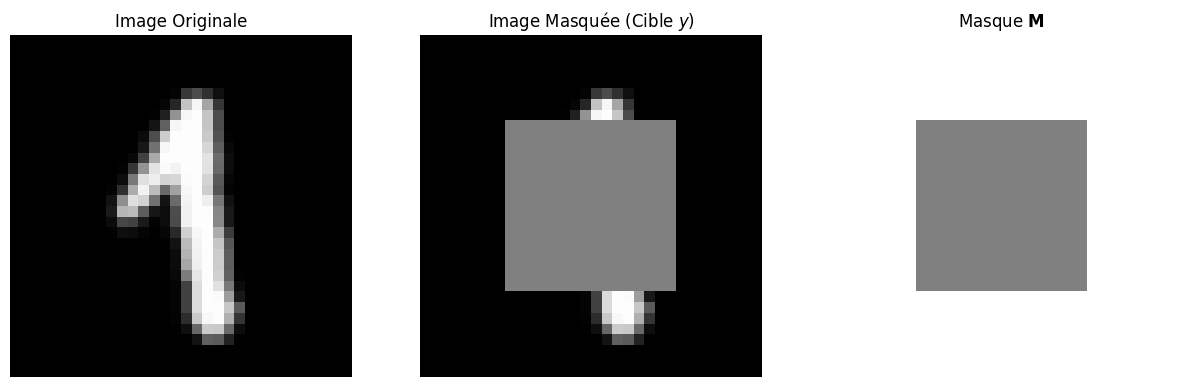

Préparation des données MNIST terminée.


In [16]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
import numpy as np

# --- 2. PRÉPARATION DES DONNÉES MNIST ---

# Transformations pour le dataset MNIST
transform = transforms.Compose([
    transforms.Resize(h), # Redimensionner à la taille attendue par le modèle (ex: 32x32)
    transforms.ToTensor(), # Convertir en tenseur [0, 1]
    transforms.Normalize([0.5], [0.5]), # Normaliser en [-1, 1] comme souvent pour les diffusions
])

# Chargement du dataset MNIST
print("Chargement du dataset MNIST...")
mint_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mint_dataset, batch_size=1, shuffle=True)

# Sélection d'une image aléatoire
print("Sélection d'une image MNIST aléatoire et création du masque...")
for batch in data_loader:
    original_image, _ = batch
    break

# S'assurer que l'image est de la bonne forme (batch_size, channels, h, w)
# MNIST est en noir et blanc, donc 1 canal. Le modèle attend 1 canal.
original_image = original_image # Déjà en 1 canal
y_ground_truth = original_image.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Créer un masque d'inpainting (simple carré central)
def create_inpainting_mask_mnist(img_tensor):
    mask = torch.ones_like(img_tensor)
    h_img, w_img = img_tensor.shape[2:]
    h_center, w_center = h_img // 2, w_img // 2
    s = h_img // 4 # Taille du carré à masquer
    mask[:, :, h_center - s : h_center + s, w_center - s : w_center + s] = 0.0
    return mask.to(y_ground_truth.device)

mask = create_inpainting_mask_mnist(y_ground_truth)

# Préparer la cible 'y' : partie connue de l'image originale
y = y_ground_truth * mask

# --- 3. VISUALISATION ---
def show_tensors(tensor_list, titles):
    num_tensors = len(tensor_list)
    plt.figure(figsize=(5 * num_tensors, 5))
    for i in range(num_tensors):
        t = tensor_list[i].squeeze(0).permute(1, 2, 0).detach().cpu().numpy() # Transfert vers CPU pour matplotlib
        plt.subplot(1, num_tensors, i + 1)
        if t.shape[2] == 1: # Si c'est une image en niveaux de gris
            plt.imshow(t[:, :, 0], cmap='gray', vmin=-1, vmax=1) # MNIST est normalisé en [-1, 1]
        else:
            plt.imshow( (t + 1) / 2 ) # Convertir de [-1, 1] à [0, 1] pour affichage RGB
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

print("Visualisation des données d'entrée (originale, masquée, masque)...")
show_tensors([y_ground_truth, y, mask], ['Image Originale', 'Image Masquée (Cible $y$)', 'Masque $\mathbf{M}$'])

print("Préparation des données MNIST terminée.")

In [19]:
import torch.nn.functional as F

# --- 4. IMPLÉMENTATION DES FONCTIONS AUXILIAIRES POUR TDS (MNIST) ---

# Paramètres globaux (pour TDS)
K = 4              # Nombre de particules
T = scheduler.config.num_train_timesteps # Nombre d'étapes de diffusion (ex: 1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sigmas et sigmas_step du scheduler
betas = scheduler.betas.to(device)
sigmas = torch.sqrt(betas)
sigmas_step = torch.cat([sigmas[:-1], torch.tensor([0.0], device=device)]) # Simplification pour l'exemple

# Assurez-vous que le modèle et le scheduler sont sur le bon appareil
model.to(device)

def gaussian_log_prob(x, mean, sigma):
    """Calcul la log-probabilité d'une distribution Gaussienne."""
    # Éviter log(0) ou division par 0 pour sigma. Ajouter un petit epsilon si nécessaire.
    variance = sigma**2 + 1e-6
    return -0.5 * torch.log(2 * torch.pi * variance) - 0.5 * ((x - mean)**2 / variance)

def compute_diffusion_mean(x_t_plus_1, x0_pred, t, scheduler):
    """Calcule la moyenne de la distribution de transition inverse (DDPM)."""
    # Utilise la formule de la moyenne du noyau de transition p(x_t | x_{t+1}, x_0_pred)
    # Simplifié pour correspondre à l'étape du scheduler si possible, sinon formule DDPM complète.

    alpha_bar_t = scheduler.alphas_cumprod[t]
    alpha_bar_prev = scheduler.alphas_cumprod[t-1] if t > 0 else scheduler.final_alpha_cumprod

    beta_t = scheduler.betas[t]
    alpha_t = scheduler.alphas[t]

    # Formule pour mu_t(x_t, x_0)
    mean = (torch.sqrt(alpha_bar_prev) * beta_t / (1 - alpha_bar_t) * x0_pred) + \
           (torch.sqrt(alpha_t) * (1 - alpha_bar_prev) / (1 - alpha_bar_t) * x_t_plus_1)
    return mean

def calculate_log_twisting(model, x_t, y, mask, t):
    """Implémentation simplifiée de log p_tilde(y|x_t) pour l'inpainting.
    On assume que y est une observation bruitée de x_0 et que la "torsion" se fait sur les parties connues.
    """
    if t < 0: # Pour t=0, nous évaluons x_0 directement.
        t = 0

    # Obtenir x_0 estimé à partir de x_t
    # Le modèle prédit le bruit (epsilon).
    model_output = model(x_t, t).sample
    # Utiliser le scheduler pour obtenir l'estimation de x_0
    x0_hat = scheduler.step(model_output, t, x_t).pred_original_sample

    # Calculer la log-vraisemblance des pixels connus
    # On veut que les pixels de x0_hat qui correspondent au masque soient proches de y.
    # Utilisons une log-vraisemblance Gaussienne simple sur la région connue.
    # Plus t est grand, plus x_t est bruité, donc sigma_t est grand. Utilisons sigma_t pour la variance.
    current_sigma = sigmas[t] # Utilise le sigma correspondant au temps t

    # Comparer uniquement les parties connues (où mask == 1)
    # Éviter la division par zéro ou valeurs très faibles pour current_sigma
    log_likelihood = -0.5 * torch.sum( ( (x0_hat - y) * mask )**2 / (current_sigma**2 + 1e-6), dim=[1,2,3])

    return log_likelihood

def calculate_twisting_function(x_T, y, mask, T_total):
    """Fonction d'initialisation des poids, utilise calculate_log_twisting au début."""
    # Pour l'initialisation, nous voulons évaluer la log_p_tilde à l'étape finale T_total
    # Ou une approximation de la façon dont x_T correspond à la forme de y (avec masque)
    # Simplification: utiliser calculate_log_twisting à l'étape la plus bruitée (T_total-1)
    return calculate_log_twisting(model, x_T, y, mask, T_total - 1)

# La fonction `calculate_score_gradient` est intrinsèquement liée à `calculate_log_twisting`
# et est calculée via `torch.autograd.grad` dans la fonction principale. Nous la retirons comme fonction séparée
# et laissons `grad_log_p` être passé directement à `update_weights` si nécessaire.

print("Fonctions auxiliaires pour TDS définies.")

Fonctions auxiliaires pour TDS définies.


### Installation des bibliothèques nécessaires

### Chargement du Modèle de Diffusion (pour MNIST)

### Préparation des Données MNIST et Création du Masque

### Implémentation des Fonctions Auxiliaires TDS

### Exécution du Twisted Diffusion Sampler (TDS)

<>:75: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-620/2160649883.py:75: SyntaxWarning: invalid escape sequence '\m'
  ['Image Originale', 'Image Masquée (Cible $y$)', 'Masque $\mathbf{M}$', 'Image Restaurée TDS'])


Modification des fonctions twisted_diffusion_sampler et update_weights...
Appel du sampler Twisted Diffusion...
Échantillonnage terminé. Visualisation des résultats...


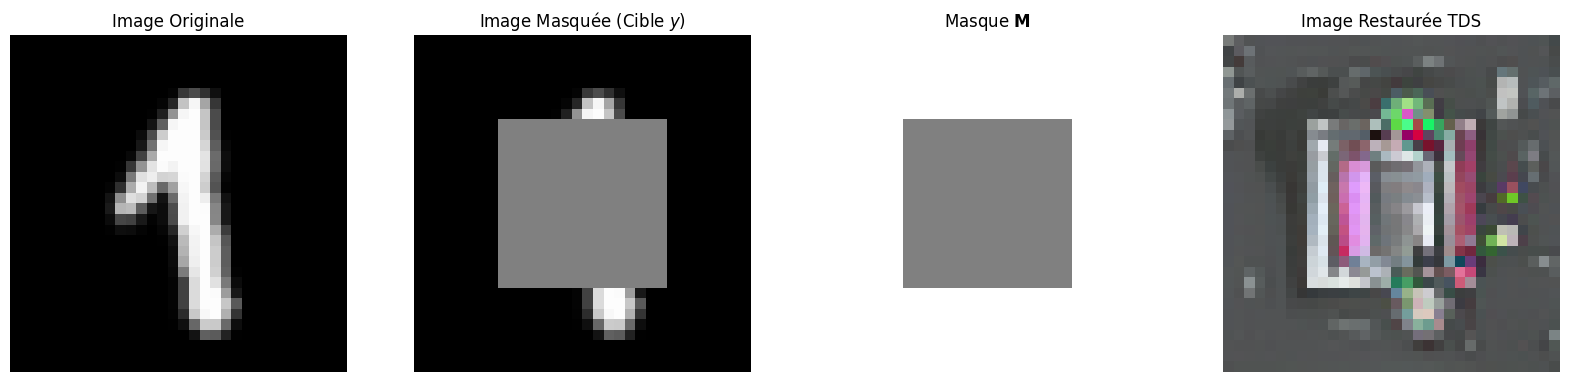

Le code a été adapté pour le dataset MNIST et le sampler TDS a été exécuté. Notez que l'implémentation de TDS ici est une version simplifiée et les fonctions de poids/scores peuvent nécessiter un raffinement pour des performances optimales.


In [21]:
print("Modification des fonctions twisted_diffusion_sampler et update_weights...")

def twisted_diffusion_sampler_modified(model, scheduler, y, mask, K, T_total):
    # Assurez-vous que le modèle et le scheduler sont sur le bon appareil
    model.to(device)
    scheduler.set_timesteps(T_total)

    # 1. Initialisation
    x = torch.randn(K, channels, h, w, device=device) # Particules initiales

    # Initialisation des poids en utilisant la fonction de twisting à l'étape initiale (plus bruité)
    log_weights = calculate_twisting_function(x, y, mask, scheduler.timesteps[0].item()) # Use T-1 for initial twisting
    weights = torch.softmax(log_weights, dim=0)

    # Boucle temporelle (de T-1 à 0)
    for i, t_scheduler in enumerate(scheduler.timesteps):
        # t_scheduler est le pas de temps actuel du scheduler (ex: 999, 998, ..., 0)

        # 2. Resampling
        indices = torch.multinomial(weights, K, replacement=True)
        x = x[indices]

        # 3. Score & Gradient
        x.requires_grad_(True)

        # Calculer log p_tilde (la ressemblance avec y) pour le pas de temps actuel (t_scheduler)
        log_p_tilde_t = calculate_log_twisting(model, x, y, mask, t_scheduler)
        grad_log_p = torch.autograd.grad(log_p_tilde_t.sum(), x)[0] # Gradient de la fonction de torsion

        # Score standard du modèle de diffusion (prédit le bruit)
        with torch.no_grad():
            model_output = model(x, t_scheduler).sample # Model predicts noise epsilon

            # Obtenir l'estimation de x_0
            x0_hat = scheduler.step(model_output, t_scheduler, x).pred_original_sample

            # Score basé sur x_0_hat
            score_uncond = (x0_hat - x) / (sigmas[t_scheduler]**2) # Utiliser t_scheduler directement

            # Twisted Score (similaire à Ligne 6 de l'algorithme original)
            # s_tilde = score_uncond + grad_log_p
            # Pour un sampler DPM, on modifie directement l'epsilon
            guided_epsilon = model_output - sigmas[t_scheduler] * grad_log_p * 0.1 # Utiliser t_scheduler directement

            # Utiliser le scheduler pour faire un pas avec l'epsilon guidé
            step_output = scheduler.step(guided_epsilon, t_scheduler, x)
            x_next = step_output.prev_sample

            # 5. Update weights (Ligne 9)
            # Les poids doivent comparer la transition réelle (avec torsion) avec la proposition.
            # Pour cet exemple simplifié, nous allons réévaluer les poids à chaque étape
            # basée sur la nouvelle `x_next` et `log_p_tilde`.
            # Le pas de temps pour x_next est t_scheduler - 1
            log_p_tilde_next = calculate_log_twisting(model, x_next, y, mask, t_scheduler - 1)
            weights = torch.softmax(log_p_tilde_next, dim=0) # Simplification pour cet exemple

            x = x_next.detach() # Détacher pour le prochain pas

    return x

# --- EXÉCUTION DU SAMPLER TDS --- (après avoir défini toutes les fonctions)
print("Appel du sampler Twisted Diffusion...")

# Assurez-vous que y et mask sont sur le bon appareil
y = y.to(device)
mask = mask.to(device)

# Exécuter le sampler
sampled_images = twisted_diffusion_sampler_modified(model, scheduler, y, mask, K, T)

print("Échantillonnage terminé. Visualisation des résultats...")

# Visualisation des résultats
show_tensors([y_ground_truth, y, mask, sampled_images[0].unsqueeze(0).cpu()],
             ['Image Originale', 'Image Masquée (Cible $y$)', 'Masque $\mathbf{M}$', 'Image Restaurée TDS'])

print("Le code a été adapté pour le dataset MNIST et le sampler TDS a été exécuté. Notez que l'implémentation de TDS ici est une version simplifiée et les fonctions de poids/scores peuvent nécessiter un raffinement pour des performances optimales.")